In [4]:
import sys, os
from os.path import split
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
from utilities import utils
from stats_tools import vis as svis
import numpy as np
from access_sif_data import load_data_tools as ld

import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
plt.rcParams["figure.dpi"] = 40
plt.style.use('ggplot')
import importlib
importlib.reload(svis)

<module 'stats_tools.vis' from 'c:\\Users\\kiril\\Thesis\\CoBra\\cobra\\stats_tools\\vis.py'>

In [5]:
TE_k = 'EchoTime'
TR_k = 'RepetitionTime'
TI_k = 'InversionTime'
FA_k = 'FlipAngle'
SD_k = 'SeriesDescription'
PID_k = 'PatientID'
time_k = 'InstanceCreationTime'
date_k = 'InstanceCreationDate'
DT_k = 'DateTime'
SID_k = 'SeriesInstanceUID'
SS_k = 'ScanningSequence'
SV_k = 'SequenceVariant'
SN_k = 'SequenceName'
SO_k = 'ScanOptions'
ETL_k = 'EchoTrainLength'
MFS_k = 'MagneticFieldStrength'

In [6]:
fig_dir = join(base_dir, 'figs')
table_dir = join(base_dir, 'data/tables')
df = utils.load_scan_csv(join(table_dir, 'neg_pos.csv'))
dfc = utils.load_scan_csv(join(table_dir, 'neg_pos_clean.csv'))
presentation_dir = f"{fig_dir}/Presentation/Study_design/figs"

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:4: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


In [8]:
df.PatientID.nunique()
len(df)

328489

In [10]:
df.StudyInstanceUID.nunique()

29172

In [17]:
input_dir = join('F:\\CoBra\\Data','volume_longitudinal_nii', 'input', 'nii_files')
seg_dir = join('F:\\CoBra\\Data','volume_longitudinal_nii', 'prediction')
input_files_ids = set([f[:6] for f in os.listdir(input_dir)])
seg_files_ids = set([f[:6] for f in os.listdir(seg_dir) if f.endswith('1mm.nii.gz')])
diff_files = input_files_ids.difference(seg_files_ids)
print(diff_files)

{'083072', '028822', '326162', '321815', '327622', '328251', '160610', '287546', '293127', '059302', '169709', '109644', '148264', '069039', '047205', '294138'}


# Patient Counts

In [4]:
print(df.PatientID.nunique(), 'Patients in total')
print(dfc.PatientID.nunique(), 'without missing date scans')

24261 Patients in total
22434 without missing date scans


## All

In [8]:
df_sp_export = df.loc[:,['PatientID', 'SeriesInstanceUID','InstanceCreationDate', 'Sequence']]
df_sp_export.to_csv("D:\Thesis\Cobra\cobra\data\share\sp\export\pat_seq.csv", index=False, header=True)

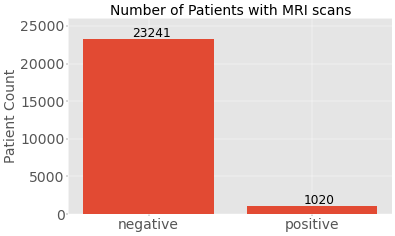

In [4]:
n_pos = 1020
n_neg = df.PatientID.nunique()-1020
labels = ['negative', 'positive']
kwargs={'xlabel':'', 'show':False, 'yrange':(0,26000),
        'ylabel':'Patient Count', 'title':'Number of Patients with MRI scans'}
fig, ax = svis.bar(labels, [n_neg, n_pos], kwargs=kwargs)
ax.text(1-.05, n_pos+300, n_pos, fontsize=22)
ax.text(0-.1, n_neg+300, n_neg, fontsize=22)
fig.savefig(f"{presentation_dir}/patient_count_tot.png", dpi=150)

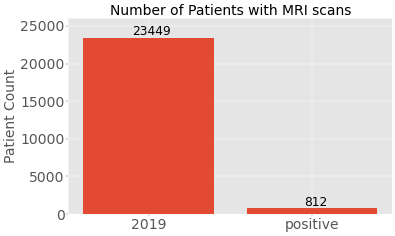

In [5]:
labels = ['2019', 'positive']
pos_mask = df.Positive==1
pos_pat_count = df[PID_k][pos_mask].nunique()
neg_pat_count = df[PID_k][~pos_mask].nunique()
counts = np.array([neg_pat_count, pos_pat_count])
kwargs={'xlabel':'', 'show':False, 'yrange':(0,26000),
        'ylabel':'Patient Count', 'title':'Number of Patients with MRI scans'}
fig, ax = svis.bar(labels, counts, kwargs=kwargs)
ax.text(1-.05, pos_pat_count+300, pos_pat_count, fontsize=22)
ax.text(0-.1, neg_pat_caount+300, neg_pat_count, fontsize=22)
fig.savefig(f"{presentation_dir}/patient_count_all.png", dpi=150)

## Remove missing dates

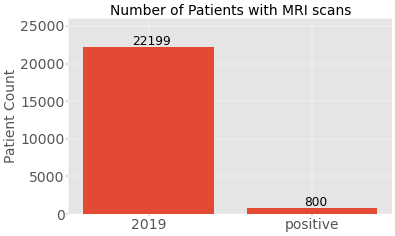

In [13]:
df = df[~df.InstanceCreationDate.isnull()]
pos_mask = df.Positive==1
pos_pat_count = df[PID_k][pos_mask].nunique()
neg_pat_count = df[PID_k][~pos_mask].nunique()
counts = np.array([neg_pat_count, pos_pat_count])
kwargs={'xlabel':'', 'show':False, 'yrange':(0,26000),
        'ylabel':'Patient Count', 'title':'Number of Patients with MRI scans'}
fig, ax = svis.bar(labels, counts, kwargs=kwargs)
ax.text(1-.05, pos_pat_count+300, pos_pat_count, fontsize=22)
ax.text(0-.1, neg_pat_count+300, neg_pat_count, fontsize=22)
fig.savefig(f"{presentation_dir}/patient_count_rm_dates.png", dpi=150)

In [14]:
print(f"There should be {df.PatientID.nunique()} patients with date")

There should be 22999 patients with date


In [34]:
#pred_seq = pd.read_csv("D:\Thesis\Cobra\cobra\data\share\sp\export\pred_seq.csv")
print(pred_seq.PatientID.nunique()) #some patients are missing
print(len(pred_seq))

22496
261000


In [30]:
df_sp_export = df.loc[:,['PatientID', 'SeriesInstanceUID','InstanceCreationDate', 'Sequence']]
df_sp_export.to_csv("D:\Thesis\Cobra\cobra\data\share\sp\export\pat_seq.csv", index=False, header=True)


In [11]:
df_sp_test = pd.read_csv("D:\Thesis\Cobra\cobra\data\share\sp\export\pat_seq.csv")
df_sp_test.PatientID.nunique()

24261

## Remove 'other' sequences

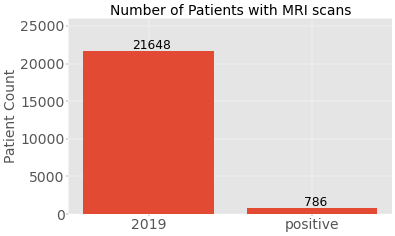

In [30]:
rel_seq = ['t2', 't1', 'flair', 'swi', 'dwi', 't2s']
df = df[df.Sequence.isin(rel_seq)]
labels = ['2019', 'positive']
pos_mask = df.Positive==1
pos_pat_count = df[PID_k][pos_mask].nunique()
neg_pat_count = df[PID_k][~pos_mask].nunique()
counts = np.array([neg_pat_count, pos_pat_count])
kwargs={'xlabel':'', 'show':False, 'yrange':(0,26000),
        'ylabel':'Patient Count', 'title':'Number of Patients with MRI scans'}
fig, ax = svis.bar(labels, counts, kwargs=kwargs)
ax.text(1-.05, pos_pat_count+300, pos_pat_count, fontsize=22)
ax.text(0-.1, neg_pat_count+300, neg_pat_count, fontsize=22)
fig.savefig(f"{presentation_dir}/patient_count_rm_dates_and_seq_other.png", dpi=150)